The notebook presents the proccess of the model tuning. Random forest is used as a prediction algorithm. Its hyperparameters are tuned via scikit-optimize with 4-fold cross-validation. The loss metric is mean absolute percentage error (MAPE). The notebook also investigates what is an appropriate way to introduce flat's floor as the model feature.  

In [117]:
from itertools import chain, combinations
import pathlib
import pickle

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from sklearn.ensemble import RandomForestRegressor
from sklearn.inspection import permutation_importance
from sklearn.metrics import make_scorer
from skopt import BayesSearchCV
from skopt.space import Real, Categorical, Integer

In [63]:
%matplotlib inline

In [176]:
PROJECT_FOLDER_PATH = pathlib.Path().resolve().parent#'C:/Users/Arenter/Documents/Python Scripts/rent/Avito'
EDA_DF_PATH = PROJECT_FOLDER_PATH / 'data/interim/eda_df.csv'
SAVE_CV_SCORES_PATH = PROJECT_FOLDER_PATH / 'data/interim/rf_cv.pickle'

In [65]:
#function for generating all subsets of a set
def powerset(iterable):
    s = list(iterable)
    return chain.from_iterable(combinations(s, r) for r in range(1, len(s)+1))

In [66]:
def mean_absolute_percentage_error(y_true, y_pred):
    return np.mean(np.abs((y_true - y_pred) / y_true)) * 100

In [178]:
def plot_feature_importances(importances, features, axis, title=None):
    importances_means = importances.importances_mean
    sorted_idx = importances_means.argsort()
    sorted_features = features[sorted_idx]
    y_ticks = np.arange(0, len(sorted_features))
    axis.barh(y_ticks, importances_means[sorted_idx])
    axis.set_yticklabels(sorted_features)
    axis.set_yticks(y_ticks)
    axis.set_title(title)
    return axis

In [191]:
#leaving only fresh publications and removing outliers 
df = pd.read_csv(EDA_DF_PATH, index_col=0, parse_dates=['parsing_date', 'pub_date', 'pub_time'])
df = df[df['pub_date'] >= pd.to_datetime('2020-08-01')]
df = df[(df['n_rooms'] < 3) & (df['y'] < 2) |
        (df['n_rooms'] == 3) & (df['y'] < 2.5) |
        (df['n_rooms'] > 3) & (df['y'] < 3.7)]

In [69]:
#Making new floor features and removing unnecessary columns
df['first_floor'] = (df['floor'] == 1).astype(int)
df['last_floor'] = (df['floor'] == df['n_floors']).astype(int)
df.drop(columns=['commission_percent', 'pub_date', 'pub_time', 'n_days', 'n_floors', 'rent'], inplace=True)

The data from advertisements published in the last 2 days (2.3 thousand observations) are reserved for evaluation set. The rest of the data (about 9 thousand observations) is used as a cross-validation set.

In [192]:
df_cv = df[df['parsing_date'] < pd.to_datetime('2020-08-13')].drop(columns='parsing_date')
df_eval = df[df['parsing_date'] >= pd.to_datetime('2020-08-13')].drop(columns='parsing_date')

The loop below brute forces different cobminations of features that relate to a flat's floor: if the floor is first, if the floor is last, and the floor number itself.

In [71]:
mape_scorer = make_scorer(mean_absolute_percentage_error, greater_is_better=False)
scores = {'subset': [],
          'model_cv': [],
          'holdout': []
          }
floor_features = ['first_floor', 'last_floor', 'floor']
regular_features = list(set(df_cv.columns) - set(floor_features + ['y']))
rf = RandomForestRegressor(n_estimators=500, criterion='mae', n_jobs=3, random_state=1)
for floor_features_subset in list(powerset(floor_features)):
    X_cv, y_cv = df_cv[regular_features + list(floor_features_subset)], df_cv['y']
    X_eval, y_eval = df_eval[regular_features + list(floor_features_subset)], df_eval['y']
    params_space = {'min_samples_leaf': Integer(1, 100),
                    'max_depth': Categorical([None, 50, 100, 200])
                    }
    opt = BayesSearchCV(rf, params_space, scoring=mape_scorer, cv=4, n_iter=20,
                        n_jobs=3, return_train_score=True, random_state=1, verbose=1)
    opt.fit(X_cv, y_cv)
    scores['subset'].append(floor_features_subset)
    scores['model_cv'].append(opt)
    scores['holdout'].append(mean_absolute_percentage_error(y_eval, opt.predict(X_eval)))

Fitting 4 folds for each of 1 candidates, totalling 4 fits


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[Parallel(n_jobs=3)]: Done   4 out of   4 | elapsed: 14.1min remaining:    0.0s
[Parallel(n_jobs=3)]: Done   4 out of   4 | elapsed: 14.1min finished
[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.


Fitting 4 folds for each of 1 candidates, totalling 4 fits


[Parallel(n_jobs=3)]: Done   4 out of   4 | elapsed: 12.8min remaining:    0.0s
[Parallel(n_jobs=3)]: Done   4 out of   4 | elapsed: 12.8min finished
[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.


Fitting 4 folds for each of 1 candidates, totalling 4 fits


[Parallel(n_jobs=3)]: Done   4 out of   4 | elapsed: 14.3min remaining:    0.0s
[Parallel(n_jobs=3)]: Done   4 out of   4 | elapsed: 14.3min finished
[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.


Fitting 4 folds for each of 1 candidates, totalling 4 fits


[Parallel(n_jobs=3)]: Done   4 out of   4 | elapsed: 12.5min remaining:    0.0s
[Parallel(n_jobs=3)]: Done   4 out of   4 | elapsed: 12.5min finished
[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.


Fitting 4 folds for each of 1 candidates, totalling 4 fits


[Parallel(n_jobs=3)]: Done   4 out of   4 | elapsed: 12.8min remaining:    0.0s
[Parallel(n_jobs=3)]: Done   4 out of   4 | elapsed: 12.8min finished
[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.


Fitting 4 folds for each of 1 candidates, totalling 4 fits


[Parallel(n_jobs=3)]: Done   4 out of   4 | elapsed: 14.2min remaining:    0.0s
[Parallel(n_jobs=3)]: Done   4 out of   4 | elapsed: 14.2min finished
[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.


Fitting 4 folds for each of 1 candidates, totalling 4 fits


[Parallel(n_jobs=3)]: Done   4 out of   4 | elapsed: 14.0min remaining:    0.0s
[Parallel(n_jobs=3)]: Done   4 out of   4 | elapsed: 14.0min finished
[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.


Fitting 4 folds for each of 1 candidates, totalling 4 fits


[Parallel(n_jobs=3)]: Done   4 out of   4 | elapsed: 12.0min remaining:    0.0s
[Parallel(n_jobs=3)]: Done   4 out of   4 | elapsed: 12.0min finished
[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.


Fitting 4 folds for each of 1 candidates, totalling 4 fits


[Parallel(n_jobs=3)]: Done   4 out of   4 | elapsed: 12.3min remaining:    0.0s
[Parallel(n_jobs=3)]: Done   4 out of   4 | elapsed: 12.3min finished


Fitting 4 folds for each of 1 candidates, totalling 4 fits


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[Parallel(n_jobs=3)]: Done   4 out of   4 | elapsed: 11.8min remaining:    0.0s
[Parallel(n_jobs=3)]: Done   4 out of   4 | elapsed: 11.8min finished


Fitting 4 folds for each of 1 candidates, totalling 4 fits


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[Parallel(n_jobs=3)]: Done   4 out of   4 | elapsed: 13.4min remaining:    0.0s
[Parallel(n_jobs=3)]: Done   4 out of   4 | elapsed: 13.4min finished


Fitting 4 folds for each of 1 candidates, totalling 4 fits


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[Parallel(n_jobs=3)]: Done   4 out of   4 | elapsed: 13.5min remaining:    0.0s
[Parallel(n_jobs=3)]: Done   4 out of   4 | elapsed: 13.5min finished


Fitting 4 folds for each of 1 candidates, totalling 4 fits


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[Parallel(n_jobs=3)]: Done   4 out of   4 | elapsed: 12.9min remaining:    0.0s
[Parallel(n_jobs=3)]: Done   4 out of   4 | elapsed: 12.9min finished


Fitting 4 folds for each of 1 candidates, totalling 4 fits


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[Parallel(n_jobs=3)]: Done   4 out of   4 | elapsed: 11.4min remaining:    0.0s
[Parallel(n_jobs=3)]: Done   4 out of   4 | elapsed: 11.4min finished


Fitting 4 folds for each of 1 candidates, totalling 4 fits


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[Parallel(n_jobs=3)]: Done   4 out of   4 | elapsed: 12.9min remaining:    0.0s
[Parallel(n_jobs=3)]: Done   4 out of   4 | elapsed: 12.9min finished
C:\Users\Arenter\anaconda3\lib\site-packages\skopt\optimizer\optimizer.py:449: UserWarning: The objective has been evaluated at this point before.
  warnings.warn("The objective has been evaluated "


Fitting 4 folds for each of 1 candidates, totalling 4 fits


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[Parallel(n_jobs=3)]: Done   4 out of   4 | elapsed: 13.9min remaining:    0.0s
[Parallel(n_jobs=3)]: Done   4 out of   4 | elapsed: 13.9min finished


Fitting 4 folds for each of 1 candidates, totalling 4 fits


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[Parallel(n_jobs=3)]: Done   4 out of   4 | elapsed: 13.2min remaining:    0.0s
[Parallel(n_jobs=3)]: Done   4 out of   4 | elapsed: 13.2min finished


Fitting 4 folds for each of 1 candidates, totalling 4 fits


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[Parallel(n_jobs=3)]: Done   4 out of   4 | elapsed: 11.7min remaining:    0.0s
[Parallel(n_jobs=3)]: Done   4 out of   4 | elapsed: 11.7min finished


Fitting 4 folds for each of 1 candidates, totalling 4 fits


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[Parallel(n_jobs=3)]: Done   4 out of   4 | elapsed: 12.2min remaining:    0.0s
[Parallel(n_jobs=3)]: Done   4 out of   4 | elapsed: 12.2min finished


Fitting 4 folds for each of 1 candidates, totalling 4 fits


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[Parallel(n_jobs=3)]: Done   4 out of   4 | elapsed: 13.6min remaining:    0.0s
[Parallel(n_jobs=3)]: Done   4 out of   4 | elapsed: 13.6min finished


Fitting 4 folds for each of 1 candidates, totalling 4 fits


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[Parallel(n_jobs=3)]: Done   4 out of   4 | elapsed: 14.0min remaining:    0.0s
[Parallel(n_jobs=3)]: Done   4 out of   4 | elapsed: 14.0min finished
[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.


Fitting 4 folds for each of 1 candidates, totalling 4 fits


[Parallel(n_jobs=3)]: Done   4 out of   4 | elapsed: 12.8min remaining:    0.0s
[Parallel(n_jobs=3)]: Done   4 out of   4 | elapsed: 12.8min finished
[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.


Fitting 4 folds for each of 1 candidates, totalling 4 fits


[Parallel(n_jobs=3)]: Done   4 out of   4 | elapsed: 18.8min remaining:    0.0s
[Parallel(n_jobs=3)]: Done   4 out of   4 | elapsed: 18.8min finished
[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.


Fitting 4 folds for each of 1 candidates, totalling 4 fits


[Parallel(n_jobs=3)]: Done   4 out of   4 | elapsed: 12.9min remaining:    0.0s
[Parallel(n_jobs=3)]: Done   4 out of   4 | elapsed: 12.9min finished
[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.


Fitting 4 folds for each of 1 candidates, totalling 4 fits


[Parallel(n_jobs=3)]: Done   4 out of   4 | elapsed: 12.7min remaining:    0.0s
[Parallel(n_jobs=3)]: Done   4 out of   4 | elapsed: 12.7min finished
[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.


Fitting 4 folds for each of 1 candidates, totalling 4 fits


[Parallel(n_jobs=3)]: Done   4 out of   4 | elapsed: 14.1min remaining:    0.0s
[Parallel(n_jobs=3)]: Done   4 out of   4 | elapsed: 14.1min finished
[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.


Fitting 4 folds for each of 1 candidates, totalling 4 fits


[Parallel(n_jobs=3)]: Done   4 out of   4 | elapsed: 14.1min remaining:    0.0s
[Parallel(n_jobs=3)]: Done   4 out of   4 | elapsed: 14.1min finished
[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.


Fitting 4 folds for each of 1 candidates, totalling 4 fits


[Parallel(n_jobs=3)]: Done   4 out of   4 | elapsed: 11.9min remaining:    0.0s
[Parallel(n_jobs=3)]: Done   4 out of   4 | elapsed: 11.9min finished
[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.


Fitting 4 folds for each of 1 candidates, totalling 4 fits


[Parallel(n_jobs=3)]: Done   4 out of   4 | elapsed: 12.7min remaining:    0.0s
[Parallel(n_jobs=3)]: Done   4 out of   4 | elapsed: 12.7min finished


Fitting 4 folds for each of 1 candidates, totalling 4 fits


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[Parallel(n_jobs=3)]: Done   4 out of   4 | elapsed: 12.2min remaining:    0.0s
[Parallel(n_jobs=3)]: Done   4 out of   4 | elapsed: 12.2min finished


Fitting 4 folds for each of 1 candidates, totalling 4 fits


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[Parallel(n_jobs=3)]: Done   4 out of   4 | elapsed: 13.1min remaining:    0.0s
[Parallel(n_jobs=3)]: Done   4 out of   4 | elapsed: 13.1min finished


Fitting 4 folds for each of 1 candidates, totalling 4 fits


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[Parallel(n_jobs=3)]: Done   4 out of   4 | elapsed: 13.7min remaining:    0.0s
[Parallel(n_jobs=3)]: Done   4 out of   4 | elapsed: 13.7min finished


Fitting 4 folds for each of 1 candidates, totalling 4 fits


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[Parallel(n_jobs=3)]: Done   4 out of   4 | elapsed: 13.1min remaining:    0.0s
[Parallel(n_jobs=3)]: Done   4 out of   4 | elapsed: 13.1min finished


Fitting 4 folds for each of 1 candidates, totalling 4 fits


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[Parallel(n_jobs=3)]: Done   4 out of   4 | elapsed: 11.4min remaining:    0.0s
[Parallel(n_jobs=3)]: Done   4 out of   4 | elapsed: 11.4min finished


Fitting 4 folds for each of 1 candidates, totalling 4 fits


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[Parallel(n_jobs=3)]: Done   4 out of   4 | elapsed: 12.8min remaining:    0.0s
[Parallel(n_jobs=3)]: Done   4 out of   4 | elapsed: 12.8min finished


Fitting 4 folds for each of 1 candidates, totalling 4 fits


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[Parallel(n_jobs=3)]: Done   4 out of   4 | elapsed: 13.3min remaining:    0.0s
[Parallel(n_jobs=3)]: Done   4 out of   4 | elapsed: 13.3min finished
C:\Users\Arenter\anaconda3\lib\site-packages\skopt\optimizer\optimizer.py:449: UserWarning: The objective has been evaluated at this point before.
  warnings.warn("The objective has been evaluated "


Fitting 4 folds for each of 1 candidates, totalling 4 fits


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[Parallel(n_jobs=3)]: Done   4 out of   4 | elapsed: 13.2min remaining:    0.0s
[Parallel(n_jobs=3)]: Done   4 out of   4 | elapsed: 13.2min finished


Fitting 4 folds for each of 1 candidates, totalling 4 fits


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[Parallel(n_jobs=3)]: Done   4 out of   4 | elapsed: 13.1min remaining:    0.0s
[Parallel(n_jobs=3)]: Done   4 out of   4 | elapsed: 13.1min finished


Fitting 4 folds for each of 1 candidates, totalling 4 fits


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[Parallel(n_jobs=3)]: Done   4 out of   4 | elapsed: 11.6min remaining:    0.0s
[Parallel(n_jobs=3)]: Done   4 out of   4 | elapsed: 11.6min finished


Fitting 4 folds for each of 1 candidates, totalling 4 fits


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[Parallel(n_jobs=3)]: Done   4 out of   4 | elapsed: 13.3min remaining:    0.0s
[Parallel(n_jobs=3)]: Done   4 out of   4 | elapsed: 13.3min finished


Fitting 4 folds for each of 1 candidates, totalling 4 fits


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[Parallel(n_jobs=3)]: Done   4 out of   4 | elapsed: 19.2min remaining:    0.0s
[Parallel(n_jobs=3)]: Done   4 out of   4 | elapsed: 19.2min finished
[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.


Fitting 4 folds for each of 1 candidates, totalling 4 fits


[Parallel(n_jobs=3)]: Done   4 out of   4 | elapsed: 18.0min remaining:    0.0s
[Parallel(n_jobs=3)]: Done   4 out of   4 | elapsed: 18.0min finished
[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.


Fitting 4 folds for each of 1 candidates, totalling 4 fits


[Parallel(n_jobs=3)]: Done   4 out of   4 | elapsed: 22.1min remaining:    0.0s
[Parallel(n_jobs=3)]: Done   4 out of   4 | elapsed: 22.1min finished
[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.


Fitting 4 folds for each of 1 candidates, totalling 4 fits


[Parallel(n_jobs=3)]: Done   4 out of   4 | elapsed: 15.2min remaining:    0.0s
[Parallel(n_jobs=3)]: Done   4 out of   4 | elapsed: 15.2min finished
[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.


Fitting 4 folds for each of 1 candidates, totalling 4 fits


[Parallel(n_jobs=3)]: Done   4 out of   4 | elapsed: 14.2min remaining:    0.0s
[Parallel(n_jobs=3)]: Done   4 out of   4 | elapsed: 14.2min finished
[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.


Fitting 4 folds for each of 1 candidates, totalling 4 fits


[Parallel(n_jobs=3)]: Done   4 out of   4 | elapsed: 14.2min remaining:    0.0s
[Parallel(n_jobs=3)]: Done   4 out of   4 | elapsed: 14.2min finished
[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.


Fitting 4 folds for each of 1 candidates, totalling 4 fits


[Parallel(n_jobs=3)]: Done   4 out of   4 | elapsed: 14.7min remaining:    0.0s
[Parallel(n_jobs=3)]: Done   4 out of   4 | elapsed: 14.7min finished
[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.


Fitting 4 folds for each of 1 candidates, totalling 4 fits


[Parallel(n_jobs=3)]: Done   4 out of   4 | elapsed: 12.6min remaining:    0.0s
[Parallel(n_jobs=3)]: Done   4 out of   4 | elapsed: 12.6min finished
[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.


Fitting 4 folds for each of 1 candidates, totalling 4 fits


[Parallel(n_jobs=3)]: Done   4 out of   4 | elapsed: 12.9min remaining:    0.0s
[Parallel(n_jobs=3)]: Done   4 out of   4 | elapsed: 12.9min finished


Fitting 4 folds for each of 1 candidates, totalling 4 fits


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[Parallel(n_jobs=3)]: Done   4 out of   4 | elapsed: 12.8min remaining:    0.0s
[Parallel(n_jobs=3)]: Done   4 out of   4 | elapsed: 12.8min finished


Fitting 4 folds for each of 1 candidates, totalling 4 fits


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[Parallel(n_jobs=3)]: Done   4 out of   4 | elapsed: 12.4min remaining:    0.0s
[Parallel(n_jobs=3)]: Done   4 out of   4 | elapsed: 12.4min finished


Fitting 4 folds for each of 1 candidates, totalling 4 fits


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[Parallel(n_jobs=3)]: Done   4 out of   4 | elapsed: 14.1min remaining:    0.0s
[Parallel(n_jobs=3)]: Done   4 out of   4 | elapsed: 14.1min finished


Fitting 4 folds for each of 1 candidates, totalling 4 fits


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[Parallel(n_jobs=3)]: Done   4 out of   4 | elapsed: 15.2min remaining:    0.0s
[Parallel(n_jobs=3)]: Done   4 out of   4 | elapsed: 15.2min finished
[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.


Fitting 4 folds for each of 1 candidates, totalling 4 fits


[Parallel(n_jobs=3)]: Done   4 out of   4 | elapsed: 15.7min remaining:    0.0s
[Parallel(n_jobs=3)]: Done   4 out of   4 | elapsed: 15.7min finished


Fitting 4 folds for each of 1 candidates, totalling 4 fits


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[Parallel(n_jobs=3)]: Done   4 out of   4 | elapsed: 15.4min remaining:    0.0s
[Parallel(n_jobs=3)]: Done   4 out of   4 | elapsed: 15.4min finished


Fitting 4 folds for each of 1 candidates, totalling 4 fits


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[Parallel(n_jobs=3)]: Done   4 out of   4 | elapsed: 15.0min remaining:    0.0s
[Parallel(n_jobs=3)]: Done   4 out of   4 | elapsed: 15.0min finished


Fitting 4 folds for each of 1 candidates, totalling 4 fits


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[Parallel(n_jobs=3)]: Done   4 out of   4 | elapsed: 15.0min remaining:    0.0s
[Parallel(n_jobs=3)]: Done   4 out of   4 | elapsed: 15.0min finished


Fitting 4 folds for each of 1 candidates, totalling 4 fits


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[Parallel(n_jobs=3)]: Done   4 out of   4 | elapsed: 14.2min remaining:    0.0s
[Parallel(n_jobs=3)]: Done   4 out of   4 | elapsed: 14.2min finished


Fitting 4 folds for each of 1 candidates, totalling 4 fits


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[Parallel(n_jobs=3)]: Done   4 out of   4 | elapsed: 12.6min remaining:    0.0s
[Parallel(n_jobs=3)]: Done   4 out of   4 | elapsed: 12.6min finished


Fitting 4 folds for each of 1 candidates, totalling 4 fits


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[Parallel(n_jobs=3)]: Done   4 out of   4 | elapsed: 14.1min remaining:    0.0s
[Parallel(n_jobs=3)]: Done   4 out of   4 | elapsed: 14.1min finished


Fitting 4 folds for each of 1 candidates, totalling 4 fits


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[Parallel(n_jobs=3)]: Done   4 out of   4 | elapsed: 15.0min remaining:    0.0s
[Parallel(n_jobs=3)]: Done   4 out of   4 | elapsed: 15.0min finished
[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.


Fitting 4 folds for each of 1 candidates, totalling 4 fits


[Parallel(n_jobs=3)]: Done   4 out of   4 | elapsed: 13.9min remaining:    0.0s
[Parallel(n_jobs=3)]: Done   4 out of   4 | elapsed: 13.9min finished
[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.


Fitting 4 folds for each of 1 candidates, totalling 4 fits


[Parallel(n_jobs=3)]: Done   4 out of   4 | elapsed: 15.6min remaining:    0.0s
[Parallel(n_jobs=3)]: Done   4 out of   4 | elapsed: 15.6min finished
[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.


Fitting 4 folds for each of 1 candidates, totalling 4 fits


[Parallel(n_jobs=3)]: Done   4 out of   4 | elapsed: 16.2min remaining:    0.0s
[Parallel(n_jobs=3)]: Done   4 out of   4 | elapsed: 16.2min finished
[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.


Fitting 4 folds for each of 1 candidates, totalling 4 fits


[Parallel(n_jobs=3)]: Done   4 out of   4 | elapsed: 12.7min remaining:    0.0s
[Parallel(n_jobs=3)]: Done   4 out of   4 | elapsed: 12.7min finished
[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.


Fitting 4 folds for each of 1 candidates, totalling 4 fits


[Parallel(n_jobs=3)]: Done   4 out of   4 | elapsed: 12.5min remaining:    0.0s
[Parallel(n_jobs=3)]: Done   4 out of   4 | elapsed: 12.5min finished
[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.


Fitting 4 folds for each of 1 candidates, totalling 4 fits


[Parallel(n_jobs=3)]: Done   4 out of   4 | elapsed: 13.7min remaining:    0.0s
[Parallel(n_jobs=3)]: Done   4 out of   4 | elapsed: 13.7min finished
[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.


Fitting 4 folds for each of 1 candidates, totalling 4 fits


[Parallel(n_jobs=3)]: Done   4 out of   4 | elapsed: 12.2min remaining:    0.0s
[Parallel(n_jobs=3)]: Done   4 out of   4 | elapsed: 12.2min finished
[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.


Fitting 4 folds for each of 1 candidates, totalling 4 fits


[Parallel(n_jobs=3)]: Done   4 out of   4 | elapsed: 12.3min remaining:    0.0s
[Parallel(n_jobs=3)]: Done   4 out of   4 | elapsed: 12.3min finished


Fitting 4 folds for each of 1 candidates, totalling 4 fits


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[Parallel(n_jobs=3)]: Done   4 out of   4 | elapsed: 12.0min remaining:    0.0s
[Parallel(n_jobs=3)]: Done   4 out of   4 | elapsed: 12.0min finished


Fitting 4 folds for each of 1 candidates, totalling 4 fits


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[Parallel(n_jobs=3)]: Done   4 out of   4 | elapsed: 13.7min remaining:    0.0s
[Parallel(n_jobs=3)]: Done   4 out of   4 | elapsed: 13.7min finished


Fitting 4 folds for each of 1 candidates, totalling 4 fits


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[Parallel(n_jobs=3)]: Done   4 out of   4 | elapsed: 13.8min remaining:    0.0s
[Parallel(n_jobs=3)]: Done   4 out of   4 | elapsed: 13.8min finished


Fitting 4 folds for each of 1 candidates, totalling 4 fits


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[Parallel(n_jobs=3)]: Done   4 out of   4 | elapsed: 13.2min remaining:    0.0s
[Parallel(n_jobs=3)]: Done   4 out of   4 | elapsed: 13.2min finished


Fitting 4 folds for each of 1 candidates, totalling 4 fits


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[Parallel(n_jobs=3)]: Done   4 out of   4 | elapsed: 11.6min remaining:    0.0s
[Parallel(n_jobs=3)]: Done   4 out of   4 | elapsed: 11.6min finished


Fitting 4 folds for each of 1 candidates, totalling 4 fits


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[Parallel(n_jobs=3)]: Done   4 out of   4 | elapsed: 13.1min remaining:    0.0s
[Parallel(n_jobs=3)]: Done   4 out of   4 | elapsed: 13.1min finished


Fitting 4 folds for each of 1 candidates, totalling 4 fits


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[Parallel(n_jobs=3)]: Done   4 out of   4 | elapsed: 13.7min remaining:    0.0s
[Parallel(n_jobs=3)]: Done   4 out of   4 | elapsed: 13.7min finished


Fitting 4 folds for each of 1 candidates, totalling 4 fits


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[Parallel(n_jobs=3)]: Done   4 out of   4 | elapsed: 13.4min remaining:    0.0s
[Parallel(n_jobs=3)]: Done   4 out of   4 | elapsed: 13.4min finished


Fitting 4 folds for each of 1 candidates, totalling 4 fits


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[Parallel(n_jobs=3)]: Done   4 out of   4 | elapsed: 13.8min remaining:    0.0s
[Parallel(n_jobs=3)]: Done   4 out of   4 | elapsed: 13.8min finished


Fitting 4 folds for each of 1 candidates, totalling 4 fits


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[Parallel(n_jobs=3)]: Done   4 out of   4 | elapsed: 13.9min remaining:    0.0s
[Parallel(n_jobs=3)]: Done   4 out of   4 | elapsed: 13.9min finished


Fitting 4 folds for each of 1 candidates, totalling 4 fits


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[Parallel(n_jobs=3)]: Done   4 out of   4 | elapsed: 13.9min remaining:    0.0s
[Parallel(n_jobs=3)]: Done   4 out of   4 | elapsed: 13.9min finished


Fitting 4 folds for each of 1 candidates, totalling 4 fits


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[Parallel(n_jobs=3)]: Done   4 out of   4 | elapsed: 15.0min remaining:    0.0s
[Parallel(n_jobs=3)]: Done   4 out of   4 | elapsed: 15.0min finished
[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.


Fitting 4 folds for each of 1 candidates, totalling 4 fits


[Parallel(n_jobs=3)]: Done   4 out of   4 | elapsed: 13.9min remaining:    0.0s
[Parallel(n_jobs=3)]: Done   4 out of   4 | elapsed: 13.9min finished
[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.


Fitting 4 folds for each of 1 candidates, totalling 4 fits


[Parallel(n_jobs=3)]: Done   4 out of   4 | elapsed: 15.7min remaining:    0.0s
[Parallel(n_jobs=3)]: Done   4 out of   4 | elapsed: 15.7min finished
[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.


Fitting 4 folds for each of 1 candidates, totalling 4 fits


[Parallel(n_jobs=3)]: Done   4 out of   4 | elapsed: 13.6min remaining:    0.0s
[Parallel(n_jobs=3)]: Done   4 out of   4 | elapsed: 13.6min finished
[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.


Fitting 4 folds for each of 1 candidates, totalling 4 fits


[Parallel(n_jobs=3)]: Done   4 out of   4 | elapsed: 13.8min remaining:    0.0s
[Parallel(n_jobs=3)]: Done   4 out of   4 | elapsed: 13.8min finished
[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.


Fitting 4 folds for each of 1 candidates, totalling 4 fits


[Parallel(n_jobs=3)]: Done   4 out of   4 | elapsed: 13.6min remaining:    0.0s
[Parallel(n_jobs=3)]: Done   4 out of   4 | elapsed: 13.6min finished
[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.


Fitting 4 folds for each of 1 candidates, totalling 4 fits


[Parallel(n_jobs=3)]: Done   4 out of   4 | elapsed: 14.6min remaining:    0.0s
[Parallel(n_jobs=3)]: Done   4 out of   4 | elapsed: 14.6min finished
[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.


Fitting 4 folds for each of 1 candidates, totalling 4 fits


[Parallel(n_jobs=3)]: Done   4 out of   4 | elapsed: 13.0min remaining:    0.0s
[Parallel(n_jobs=3)]: Done   4 out of   4 | elapsed: 13.0min finished
[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.


Fitting 4 folds for each of 1 candidates, totalling 4 fits


[Parallel(n_jobs=3)]: Done   4 out of   4 | elapsed: 13.4min remaining:    0.0s
[Parallel(n_jobs=3)]: Done   4 out of   4 | elapsed: 13.4min finished


Fitting 4 folds for each of 1 candidates, totalling 4 fits


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[Parallel(n_jobs=3)]: Done   4 out of   4 | elapsed: 13.1min remaining:    0.0s
[Parallel(n_jobs=3)]: Done   4 out of   4 | elapsed: 13.1min finished


Fitting 4 folds for each of 1 candidates, totalling 4 fits


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[Parallel(n_jobs=3)]: Done   4 out of   4 | elapsed: 14.5min remaining:    0.0s
[Parallel(n_jobs=3)]: Done   4 out of   4 | elapsed: 14.5min finished


Fitting 4 folds for each of 1 candidates, totalling 4 fits


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[Parallel(n_jobs=3)]: Done   4 out of   4 | elapsed: 14.8min remaining:    0.0s
[Parallel(n_jobs=3)]: Done   4 out of   4 | elapsed: 14.8min finished


Fitting 4 folds for each of 1 candidates, totalling 4 fits


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[Parallel(n_jobs=3)]: Done   4 out of   4 | elapsed: 12.6min remaining:    0.0s
[Parallel(n_jobs=3)]: Done   4 out of   4 | elapsed: 12.6min finished


Fitting 4 folds for each of 1 candidates, totalling 4 fits


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[Parallel(n_jobs=3)]: Done   4 out of   4 | elapsed: 14.8min remaining:    0.0s
[Parallel(n_jobs=3)]: Done   4 out of   4 | elapsed: 14.8min finished


Fitting 4 folds for each of 1 candidates, totalling 4 fits


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[Parallel(n_jobs=3)]: Done   4 out of   4 | elapsed: 14.1min remaining:    0.0s
[Parallel(n_jobs=3)]: Done   4 out of   4 | elapsed: 14.1min finished


Fitting 4 folds for each of 1 candidates, totalling 4 fits


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[Parallel(n_jobs=3)]: Done   4 out of   4 | elapsed: 14.8min remaining:    0.0s
[Parallel(n_jobs=3)]: Done   4 out of   4 | elapsed: 14.8min finished


Fitting 4 folds for each of 1 candidates, totalling 4 fits


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[Parallel(n_jobs=3)]: Done   4 out of   4 | elapsed: 12.7min remaining:    0.0s
[Parallel(n_jobs=3)]: Done   4 out of   4 | elapsed: 12.7min finished


Fitting 4 folds for each of 1 candidates, totalling 4 fits


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[Parallel(n_jobs=3)]: Done   4 out of   4 | elapsed: 16.2min remaining:    0.0s
[Parallel(n_jobs=3)]: Done   4 out of   4 | elapsed: 16.2min finished


Fitting 4 folds for each of 1 candidates, totalling 4 fits


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[Parallel(n_jobs=3)]: Done   4 out of   4 | elapsed: 17.5min remaining:    0.0s
[Parallel(n_jobs=3)]: Done   4 out of   4 | elapsed: 17.5min finished


Fitting 4 folds for each of 1 candidates, totalling 4 fits


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[Parallel(n_jobs=3)]: Done   4 out of   4 | elapsed: 14.0min remaining:    0.0s
[Parallel(n_jobs=3)]: Done   4 out of   4 | elapsed: 14.0min finished


Fitting 4 folds for each of 1 candidates, totalling 4 fits


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[Parallel(n_jobs=3)]: Done   4 out of   4 | elapsed: 15.0min remaining:    0.0s
[Parallel(n_jobs=3)]: Done   4 out of   4 | elapsed: 15.0min finished
[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.


Fitting 4 folds for each of 1 candidates, totalling 4 fits


[Parallel(n_jobs=3)]: Done   4 out of   4 | elapsed: 13.9min remaining:    0.0s
[Parallel(n_jobs=3)]: Done   4 out of   4 | elapsed: 13.9min finished
[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.


Fitting 4 folds for each of 1 candidates, totalling 4 fits


[Parallel(n_jobs=3)]: Done   4 out of   4 | elapsed: 15.7min remaining:    0.0s
[Parallel(n_jobs=3)]: Done   4 out of   4 | elapsed: 15.7min finished
[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.


Fitting 4 folds for each of 1 candidates, totalling 4 fits


[Parallel(n_jobs=3)]: Done   4 out of   4 | elapsed: 13.7min remaining:    0.0s
[Parallel(n_jobs=3)]: Done   4 out of   4 | elapsed: 13.7min finished
[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.


Fitting 4 folds for each of 1 candidates, totalling 4 fits


[Parallel(n_jobs=3)]: Done   4 out of   4 | elapsed: 13.8min remaining:    0.0s
[Parallel(n_jobs=3)]: Done   4 out of   4 | elapsed: 13.8min finished
[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.


Fitting 4 folds for each of 1 candidates, totalling 4 fits


[Parallel(n_jobs=3)]: Done   4 out of   4 | elapsed: 13.6min remaining:    0.0s
[Parallel(n_jobs=3)]: Done   4 out of   4 | elapsed: 13.6min finished
[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.


Fitting 4 folds for each of 1 candidates, totalling 4 fits


[Parallel(n_jobs=3)]: Done   4 out of   4 | elapsed: 14.7min remaining:    0.0s
[Parallel(n_jobs=3)]: Done   4 out of   4 | elapsed: 14.7min finished
[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.


Fitting 4 folds for each of 1 candidates, totalling 4 fits


[Parallel(n_jobs=3)]: Done   4 out of   4 | elapsed: 13.0min remaining:    0.0s
[Parallel(n_jobs=3)]: Done   4 out of   4 | elapsed: 13.0min finished
[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.


Fitting 4 folds for each of 1 candidates, totalling 4 fits


[Parallel(n_jobs=3)]: Done   4 out of   4 | elapsed: 13.4min remaining:    0.0s
[Parallel(n_jobs=3)]: Done   4 out of   4 | elapsed: 13.4min finished


Fitting 4 folds for each of 1 candidates, totalling 4 fits


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[Parallel(n_jobs=3)]: Done   4 out of   4 | elapsed: 13.1min remaining:    0.0s
[Parallel(n_jobs=3)]: Done   4 out of   4 | elapsed: 13.1min finished


Fitting 4 folds for each of 1 candidates, totalling 4 fits


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[Parallel(n_jobs=3)]: Done   4 out of   4 | elapsed: 12.6min remaining:    0.0s
[Parallel(n_jobs=3)]: Done   4 out of   4 | elapsed: 12.6min finished


Fitting 4 folds for each of 1 candidates, totalling 4 fits


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[Parallel(n_jobs=3)]: Done   4 out of   4 | elapsed: 14.5min remaining:    0.0s
[Parallel(n_jobs=3)]: Done   4 out of   4 | elapsed: 14.5min finished


Fitting 4 folds for each of 1 candidates, totalling 4 fits


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[Parallel(n_jobs=3)]: Done   4 out of   4 | elapsed: 14.7min remaining:    0.0s
[Parallel(n_jobs=3)]: Done   4 out of   4 | elapsed: 14.7min finished


Fitting 4 folds for each of 1 candidates, totalling 4 fits


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[Parallel(n_jobs=3)]: Done   4 out of   4 | elapsed: 14.5min remaining:    0.0s
[Parallel(n_jobs=3)]: Done   4 out of   4 | elapsed: 14.5min finished


Fitting 4 folds for each of 1 candidates, totalling 4 fits


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[Parallel(n_jobs=3)]: Done   4 out of   4 | elapsed: 14.2min remaining:    0.0s
[Parallel(n_jobs=3)]: Done   4 out of   4 | elapsed: 14.2min finished


Fitting 4 folds for each of 1 candidates, totalling 4 fits


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[Parallel(n_jobs=3)]: Done   4 out of   4 | elapsed: 14.9min remaining:    0.0s
[Parallel(n_jobs=3)]: Done   4 out of   4 | elapsed: 14.9min finished


Fitting 4 folds for each of 1 candidates, totalling 4 fits


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[Parallel(n_jobs=3)]: Done   4 out of   4 | elapsed: 15.0min remaining:    0.0s
[Parallel(n_jobs=3)]: Done   4 out of   4 | elapsed: 15.0min finished


Fitting 4 folds for each of 1 candidates, totalling 4 fits


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[Parallel(n_jobs=3)]: Done   4 out of   4 | elapsed: 12.8min remaining:    0.0s
[Parallel(n_jobs=3)]: Done   4 out of   4 | elapsed: 12.8min finished


Fitting 4 folds for each of 1 candidates, totalling 4 fits


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[Parallel(n_jobs=3)]: Done   4 out of   4 | elapsed: 15.0min remaining:    0.0s
[Parallel(n_jobs=3)]: Done   4 out of   4 | elapsed: 15.0min finished


Fitting 4 folds for each of 1 candidates, totalling 4 fits


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[Parallel(n_jobs=3)]: Done   4 out of   4 | elapsed: 14.1min remaining:    0.0s
[Parallel(n_jobs=3)]: Done   4 out of   4 | elapsed: 14.1min finished


Fitting 4 folds for each of 1 candidates, totalling 4 fits


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[Parallel(n_jobs=3)]: Done   4 out of   4 | elapsed: 16.0min remaining:    0.0s
[Parallel(n_jobs=3)]: Done   4 out of   4 | elapsed: 16.0min finished
[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.


Fitting 4 folds for each of 1 candidates, totalling 4 fits


[Parallel(n_jobs=3)]: Done   4 out of   4 | elapsed: 14.7min remaining:    0.0s
[Parallel(n_jobs=3)]: Done   4 out of   4 | elapsed: 14.7min finished
[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.


Fitting 4 folds for each of 1 candidates, totalling 4 fits


[Parallel(n_jobs=3)]: Done   4 out of   4 | elapsed: 16.8min remaining:    0.0s
[Parallel(n_jobs=3)]: Done   4 out of   4 | elapsed: 16.8min finished
[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.


Fitting 4 folds for each of 1 candidates, totalling 4 fits


[Parallel(n_jobs=3)]: Done   4 out of   4 | elapsed: 14.5min remaining:    0.0s
[Parallel(n_jobs=3)]: Done   4 out of   4 | elapsed: 14.5min finished
[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.


Fitting 4 folds for each of 1 candidates, totalling 4 fits


[Parallel(n_jobs=3)]: Done   4 out of   4 | elapsed: 14.6min remaining:    0.0s
[Parallel(n_jobs=3)]: Done   4 out of   4 | elapsed: 14.6min finished
[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.


Fitting 4 folds for each of 1 candidates, totalling 4 fits


[Parallel(n_jobs=3)]: Done   4 out of   4 | elapsed: 14.4min remaining:    0.0s
[Parallel(n_jobs=3)]: Done   4 out of   4 | elapsed: 14.4min finished
[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.


Fitting 4 folds for each of 1 candidates, totalling 4 fits


[Parallel(n_jobs=3)]: Done   4 out of   4 | elapsed: 15.6min remaining:    0.0s
[Parallel(n_jobs=3)]: Done   4 out of   4 | elapsed: 15.6min finished
[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.


Fitting 4 folds for each of 1 candidates, totalling 4 fits


[Parallel(n_jobs=3)]: Done   4 out of   4 | elapsed: 13.8min remaining:    0.0s
[Parallel(n_jobs=3)]: Done   4 out of   4 | elapsed: 13.8min finished
[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.


Fitting 4 folds for each of 1 candidates, totalling 4 fits


[Parallel(n_jobs=3)]: Done   4 out of   4 | elapsed: 14.2min remaining:    0.0s
[Parallel(n_jobs=3)]: Done   4 out of   4 | elapsed: 14.2min finished


Fitting 4 folds for each of 1 candidates, totalling 4 fits


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[Parallel(n_jobs=3)]: Done   4 out of   4 | elapsed: 13.9min remaining:    0.0s
[Parallel(n_jobs=3)]: Done   4 out of   4 | elapsed: 13.9min finished


Fitting 4 folds for each of 1 candidates, totalling 4 fits


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[Parallel(n_jobs=3)]: Done   4 out of   4 | elapsed: 15.4min remaining:    0.0s
[Parallel(n_jobs=3)]: Done   4 out of   4 | elapsed: 15.4min finished


Fitting 4 folds for each of 1 candidates, totalling 4 fits


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[Parallel(n_jobs=3)]: Done   4 out of   4 | elapsed: 15.4min remaining:    0.0s
[Parallel(n_jobs=3)]: Done   4 out of   4 | elapsed: 15.4min finished


Fitting 4 folds for each of 1 candidates, totalling 4 fits


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[Parallel(n_jobs=3)]: Done   4 out of   4 | elapsed: 15.7min remaining:    0.0s
[Parallel(n_jobs=3)]: Done   4 out of   4 | elapsed: 15.7min finished


Fitting 4 folds for each of 1 candidates, totalling 4 fits


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[Parallel(n_jobs=3)]: Done   4 out of   4 | elapsed: 13.4min remaining:    0.0s
[Parallel(n_jobs=3)]: Done   4 out of   4 | elapsed: 13.4min finished


Fitting 4 folds for each of 1 candidates, totalling 4 fits


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[Parallel(n_jobs=3)]: Done   4 out of   4 | elapsed: 15.2min remaining:    0.0s
[Parallel(n_jobs=3)]: Done   4 out of   4 | elapsed: 15.2min finished


Fitting 4 folds for each of 1 candidates, totalling 4 fits


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[Parallel(n_jobs=3)]: Done   4 out of   4 | elapsed: 15.8min remaining:    0.0s
[Parallel(n_jobs=3)]: Done   4 out of   4 | elapsed: 15.8min finished


Fitting 4 folds for each of 1 candidates, totalling 4 fits


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[Parallel(n_jobs=3)]: Done   4 out of   4 | elapsed: 15.9min remaining:    0.0s
[Parallel(n_jobs=3)]: Done   4 out of   4 | elapsed: 15.9min finished


Fitting 4 folds for each of 1 candidates, totalling 4 fits


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[Parallel(n_jobs=3)]: Done   4 out of   4 | elapsed: 13.6min remaining:    0.0s
[Parallel(n_jobs=3)]: Done   4 out of   4 | elapsed: 13.6min finished


Fitting 4 folds for each of 1 candidates, totalling 4 fits


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[Parallel(n_jobs=3)]: Done   4 out of   4 | elapsed: 16.0min remaining:    0.0s
[Parallel(n_jobs=3)]: Done   4 out of   4 | elapsed: 16.0min finished


Fitting 4 folds for each of 1 candidates, totalling 4 fits


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[Parallel(n_jobs=3)]: Done   4 out of   4 | elapsed: 14.0min remaining:    0.0s
[Parallel(n_jobs=3)]: Done   4 out of   4 | elapsed: 14.0min finished


MAPE is essentially the same on cross-validation and holdout data for all combinations of features. So I will choose the model with the smallest number of features, namely the one that contains 'floor' itself. 

In [184]:
list(zip(scores['holdout'], [m.best_score_ for m in scores['model_cv']]))

[(15.875364799245109, -15.949106196048023),
 (15.867489272582775, -15.957395478553579),
 (15.819357218105518, -15.837495969961095),
 (15.875613044722932, -15.951705543875468),
 (15.818333361862678, -15.850456498777751),
 (15.824938151105089, -15.83886916859718),
 (15.823005416308956, -15.842797102438434)]

In [188]:
subset_ind = 3
scores['model_cv'][subset_ind].best_estimator_

RandomForestRegressor(criterion='mae', min_samples_leaf=7, n_estimators=500,
                      n_jobs=3, random_state=1)

In [181]:
floor_features_subset = scores['subset'][subset_ind]
X_train, y_train = df_cv[regular_features + list(floor_features_subset)], df_cv['y']
X_test, y_test = df_eval[regular_features + list(floor_features_subset)], df_eval['y']
model = scores['model_cv'][subset_ind].best_estimator_
train_importances = permutation_importance(model, X_train, y_train, scoring=mape_scorer, random_state=1)
test_importances = permutation_importance(model, X_test, y_test, scoring=mape_scorer, random_state=1)

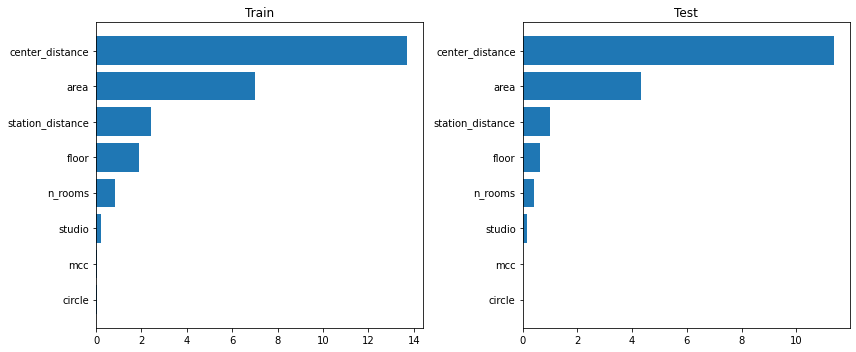

In [182]:
fig, ax = plt.subplots(1, 2, figsize=(12, 5))
plot_feature_importances(train_importances, X_train.columns, ax[0], 'Train')
plot_feature_importances(test_importances, X_test.columns, ax[1], 'Test')
plt.tight_layout()